## Для каждого "прогнозирования" необходимо найти лучшие параметры

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

In [2]:
hist = yf.download('MSFT', period='1y')

[*********************100%***********************]  1 of 1 completed


In [3]:
hist.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-07,221.990005,228.410004,221.279999,227.869995,225.689667,33498000
2022-11-08,228.699997,231.649994,225.839996,228.869995,226.680084,28192500
2022-11-09,227.369995,228.630005,224.330002,224.509995,222.361801,27852900
2022-11-10,235.429993,243.330002,235.000000,242.979996,240.655075,46268000
2022-11-11,242.990005,247.990005,241.929993,247.110001,244.745575,34620200


### 1) create a linear forecast for stock price based on data for N days


In [4]:
N = 7

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
hist[['Adj Close']][-14:-7]

,Adj Close
Date,
2023-10-18,330.109985
2023-10-19,331.320007
2023-10-20,326.670013
2023-10-23,329.320007
2023-10-24,330.529999
2023-10-25,340.670013
2023-10-26,327.890015


In [7]:
df = hist[['Adj Close']][-14:-7]

X = np.array(range(len(df))).reshape(-1, 1)
y = df['Adj Close'].values

In [8]:
X # Days as features

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6]])

In [9]:
y # Stock prices as target variable

array([330.10998535, 331.32000732, 326.67001343, 329.32000732,
       330.52999878, 340.67001343, 327.89001465])

In [10]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [11]:
future_days = np.array(range(len(df), len(df) + N)).reshape(-1, 1)  # Days for the next 7 days
forecast = model.predict(future_days)

In [12]:
print("Forecasted prices for the next seven days:", forecast)

Forecasted prices for the next seven days: [333.20144653 333.76930673 334.33716692 334.90502712 335.47288731
 336.04074751 336.6086077 ]


In [13]:
forecast

array([333.20144653, 333.76930673, 334.33716692, 334.90502712,
       335.47288731, 336.04074751, 336.6086077 ])

### 2) for "1" assess standard error for M days ahead

In [14]:
M = 7

In [15]:
type(forecast)

numpy.ndarray

In [16]:
from sklearn.metrics import mean_squared_error

actual_prices = hist[['Adj Close']][-M:]
mse = mean_squared_error(actual_prices, forecast)

In [17]:
mse

138.68147935351953

### 3) Autocorrelation: regress consecutive daily returns by lag N

In [18]:
hist["Returns"] = hist["Adj Close"].pct_change()
hist = hist.dropna()

In [19]:
import statsmodels.api as sm

In [20]:
N = 7 # the lag for autocorrelation

In [21]:
hist[f'Lagged_Returns_{N}'] = hist['Returns'].shift(N)
hist.dropna(inplace=True)

X = hist[f'Lagged_Returns_{N}']
y = hist['Returns']

X = sm.add_constant(X)  # Adding a constant for the intercept term
model = sm.OLS(y, X).fit()

/var/folders/xd/xm863f553v750zss70sl77sc0000gn/T/ipykernel_4982/2365127761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist[f'Lagged_Returns_{N}'] = hist['Returns'].shift(N)
/var/folders/xd/xm863f553v750zss70sl77sc0000gn/T/ipykernel_4982/2365127761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist.dropna(inplace=True)


In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2634
Date:                Mon, 06 Nov 2023   Prob (F-statistic):              0.608
Time:                        21:58:21   Log-Likelihood:                 648.88
No. Observations:                 243   AIC:                            -1294.
Df Residuals:                     241   BIC:                            -1287.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0017      0.001      1.572      0.117      -0.000       0.004
Lagged_Returns_7     0.0315      0.061      0.513      0.608      -0.090       0.153
==============================================================================
Omnibus:                       18.747   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.662
Skew:                           0.487   Prob(JB):                     5.97e-07
Kurtosis:                       4.372   Cond. No.                         57.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2634
Date:                Mon, 06 Nov 2023   Prob (F-statistic):              0.608
Time:                        21:58:21   Log-Likelihood:                 648.88
No. Observations:                 243   AIC:                            -1294.
Df Residuals:                     241   BIC:                            -1287.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0017      0.001  

### 4) is stock price a Random Walk process?

We can test whether a stock price follows a random walk using Augmented Dickey-Fuller (ADF) test.

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
result = adfuller(hist['Adj Close'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.745320491574249
p-value: 0.8346587852730765


In [26]:
if result[1] <= 0.05:
    print("Reject the null hypothesis. Stock prices do not follow a random walk.")
else:
    print("Fail to reject the null hypothesis. Stock prices may follow a random walk.")


Fail to reject the null hypothesis. Stock prices may follow a random walk.


### 5) moving average forecast – find an optimal N

In [27]:
windows_dict = {
    "window_size_3": 3,
    "window_size_5": 5,
    "window_size_7": 7,
    "window_size_10": 10,
    "window_size_14": 14,
    "window_size_21": 21

}

In [28]:
for window in windows_dict:
    window_size = windows_dict[window]
    hist[f'Moving_Average_{window_size}'] = hist['Adj Close'].rolling(window=window_size).mean()

/var/folders/xd/xm863f553v750zss70sl77sc0000gn/T/ipykernel_4982/1930725849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist[f'Moving_Average_{window_size}'] = hist['Adj Close'].rolling(window=window_size).mean()
/var/folders/xd/xm863f553v750zss70sl77sc0000gn/T/ipykernel_4982/1930725849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist[f'Moving_Average_{window_size}'] = hist['Adj Close'].rolling(window=window_size).mean()
/var/folders/xd/xm863f553v750zss70sl77sc0000gn/T/ipykernel_4982/19307258

In [29]:
hist.dropna(inplace=True)

/var/folders/xd/xm863f553v750zss70sl77sc0000gn/T/ipykernel_4982/1507344685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist.dropna(inplace=True)


In [30]:
hist

,Open,High,Low,Close,Adj Close,Volume,Returns,Lagged_Returns_7,Moving_Average_3,Moving_Average_5,Moving_Average_7,Moving_Average_10,Moving_Average_14,Moving_Average_21
Date,,,,,,,,,,,,,,
2022-12-16,248.550003,249.839996,243.509995,244.690002,243.031693,86102000,-0.017349,-0.003060,248.610306,250.361685,248.755500,247.596547,248.166656,246.170279
2022-12-19,244.860001,245.210007,238.710007,240.449997,238.820435,29696400,-0.017328,0.012399,243.058182,247.966034,247.769372,246.628156,248.175170,246.112106
2022-12-20,239.399994,242.910004,238.419998,241.800003,240.161285,25150800,0.005614,-0.008003,240.671137,244.962527,247.255735,246.298407,247.228771,246.139537
2022-12-21,241.690002,245.619995,240.110001,244.429993,242.773438,23690600,0.010877,0.028889,240.585052,242.421854,246.109270,246.304366,246.500880,246.252101
2022-12-22,241.259995,241.990005,233.869995,238.190002,236.575745,28651700,-0.025529,0.017465,239.836823,240.272519,243.451688,245.389607,245.306884,245.928594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,338.850006,339.000000,334.690002,338.109985,338.109985,20265300,0.002372,-0.014035,335.076660,334.758002,333.377145,332.174002,331.809289,329.282385
2023-11-01,339.790009,347.420013,339.649994,346.070007,346.070007,28158800,0.023543,0.008112,340.496663,335.838000,335.770002,333.770004,332.874289,330.838575
2023-11-02,347.239990,348.829987,344.769989,348.320007,348.320007,24348100,0.006502,0.003674,344.166667,339.923999,338.311432,335.470004,334.345003,332.236671


<AxesSubplot:xlabel='Date'>

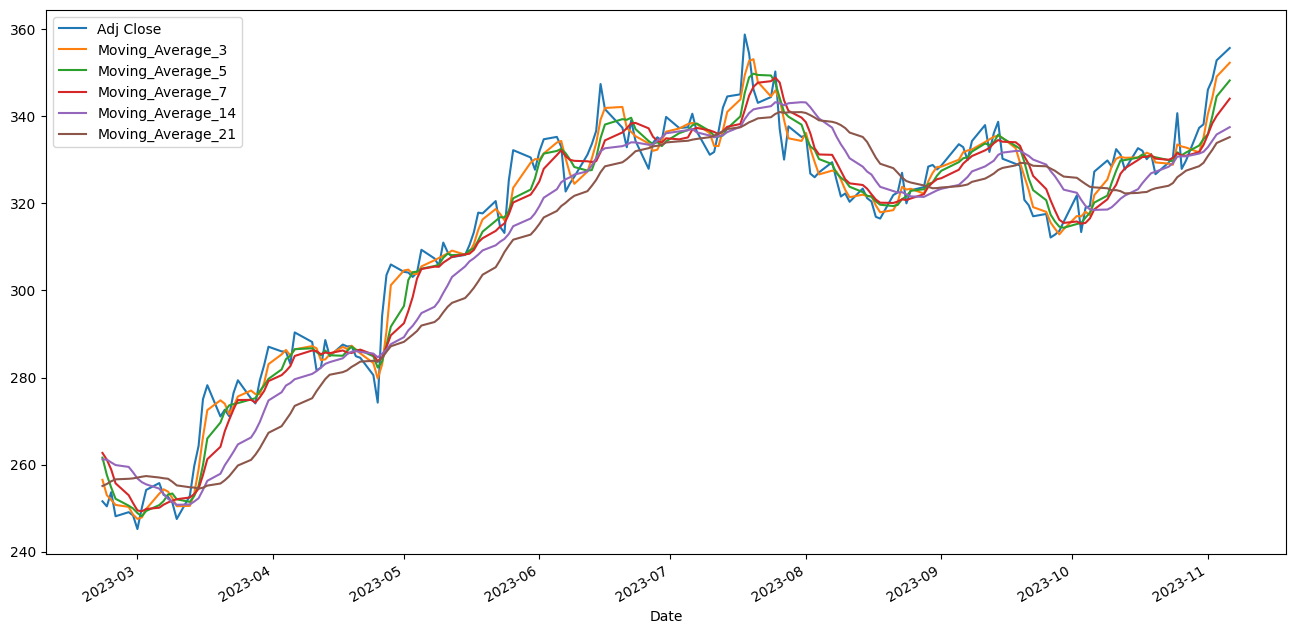

In [31]:
hist[['Adj Close',
      'Moving_Average_3',
      'Moving_Average_5',
      'Moving_Average_7',
      'Moving_Average_14',
      'Moving_Average_21'
      ]][-6*30:].plot( label='Moving average forecast',
                                  figsize=(16, 8))

judging by the plot 7-day window is most optimal

### 6) exponential smoothing forecast – find optimal parameters

In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [36]:
alpha = 0.2  # in (0; 1)

model = ExponentialSmoothing(hist['Adj Close'], trend='add', seasonal=None)
fitted_model = model.fit(smoothing_level=alpha)

forecast_values = fitted_model.forecast(steps=30)  # Forecast for the next 7 periods

print(forecast_values)

223    346.533296
224    347.025842
225    347.518388
226    348.010935
227    348.503481
228    348.996027
229    349.488574
230    349.981120
231    350.473666
232    350.966212
233    351.458759
234    351.951305
235    352.443851
236    352.936397
237    353.428944
238    353.921490
239    354.414036
240    354.906582
241    355.399129
242    355.891675
243    356.384221
244    356.876768
245    357.369314
246    357.861860
247    358.354406
248    358.846953
249    359.339499
250    359.832045
251    360.324591
252    360.817138
dtype: float64


/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/artemilin/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [45]:
alpha_values = np.linspace(0, 1, 10)
trend_values = ["add", "mul", "additive", "multiplicative", None]
seasonal_values = ["add", "mul", "additive", "multiplicative", None]
seasonal_periods_values = [7, 14, 21, 30, 60, 90]
hist_without30 = hist['Adj Close'][:-30]

best_mse = float('inf')
best_params = (0, None, None, 0)

In [ ]:
for a in alpha_values:
    for t in trend_values:
        for s in seasonal_values:
            for sp in seasonal_periods_values:

                model = ExponentialSmoothing(hist_without30, trend=t, seasonal=s, seasonal_periods=sp)
                fitted_model = model.fit(smoothing_level=a)

                forecast_values = fitted_model.forecast(steps=30)

                mse = mean_squared_error(hist['Adj Close'][-30:], forecast_values)

                if mse < best_mse:
                    best_mse = mse
                    best_params = (a, t, s, sp)

In [47]:
best_params

(0.6666666666666666, 'mul', 'add', 60)